# Molecular features of vaccine-responsive and persistent lineages

In [22]:
import sys
import os
import time
import copy

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

# myColors = ["#E69F00", "#56B4E9"]
myColors = ["#E69F00", "#56B4E9", "#666666"]

# Load data

In [23]:
# Lineage dynamics data
df_all = pd.read_csv("data/df_ClonalLineageDynamics.csv", index_col=0)

# Groups of lineages separated by dynamics
df_expanded = pd.read_csv("data/df_expanded.csv", index_col=0)
df_persistent = pd.read_csv("data/df_persistent.csv", index_col=0)

print df_all.shape
print df_expanded.shape
print df_persistent.shape

(169368, 30)
(182, 30)
(417, 30)


In [24]:
# Sequence data

def load_data_seqs(infile):
    usecols = [0, 10, 17, 22, 25, 27, 31, 37, 68, 69]
    names = ["uid", "lineage_uid", "patient_uid", "year_visit_str",
             "V_germline", "J_germline",
             "isotype", "cdr3_length",
             "mut_germline_density", "V_germline_identity"]
    dtype = dict([(col, np.object) for col in names])
    dtype["uid"] = np.int64
    dtype["lineage_uid"] = np.int64
    dtype["patient_uid"] = np.int64
    dtype["cdr3_length"] = np.int16
    dtype["mut_germline_density"] = np.float16
    dtype["V_germline_identity"] = np.float16
    df = pd.read_csv(infile, usecols=usecols, names=names, dtype=dtype, sep="\t", header=None, index_col=None, na_values=["\N"])
    df = df.loc[df["year_visit_str"] != "V6_Full"] # Exclude 2x300 sequences
    return df

df_seqs_all = load_data_seqs("data/Bcell_flu_high_res.sequences.csv")
print df_seqs_all.shape

(1779689, 10)


In [25]:
df_seqs_all.head()

,uid,lineage_uid,patient_uid,year_visit_str,V_germline,J_germline,isotype,cdr3_length,mut_germline_density,V_germline_identity
0,20102010100000000,20201010000060437,2,V1,IGHV3-48*03,IGHJ4*02,IgG,50,0.030075,0.964844
1,20102010100000002,20201010000004123,2,V1,IGHV3-11*04,IGHJ4*02,IgM,38,0.000000,1.000000
2,20102010100000003,20201010000077505,2,V1,IGHV3-11*04,IGHJ6*02,IgA,47,0.015503,1.000000
3,20102010100000004,20201010000093838,2,V1,IGHV3-30*02,IGHJ4*02,IgM,38,0.000000,1.000000
4,20102010100000006,20201010000083654,2,V1,IGHV3-64*05,IGHJ3*02,IgM,29,0.017853,0.960938


In [26]:
# Subset for sequences in lineages separated by dynamics
df_seqs = df_seqs_all[df_seqs_all["lineage_uid"].isin(list(df_expanded.index) + list(df_persistent.index))]
print df_seqs.shape

# Write to file
# df_seqs.to_csv("data/df_seqs.filtered.csv")

(694385, 10)


In [27]:
# Subset for expanded and persistent sequences
df_seqs_expanded = df_seqs[df_seqs["lineage_uid"].isin(list(df_expanded.index))]
df_seqs_persistent = df_seqs[df_seqs["lineage_uid"].isin(list(df_persistent.index))]

# Plot distribution of lineage size at D7

In [38]:
# Calculate total number of sequences detected (including or excluding 2x300 reads)

col_names = ["sequences_V" + str(i) for i in xrange(1,9)]
df_expanded["num_unique_seqs_no_V6_Full"] = np.sum(df_expanded[col_names], axis=1)

col_names = ["sequences_V" + str(i) for i in xrange(1,9)] + ["sequences_V6_Full"]
df_expanded["num_unique_seqs"] = np.sum(df_expanded[col_names], axis=1)

col_names = ["sequences_V" + str(i) for i in xrange(1,9)]
df_persistent["num_unique_seqs_no_V6_Full"] = np.sum(df_persistent[col_names], axis=1)

col_names = ["sequences_V" + str(i) for i in xrange(1,9)] + ["sequences_V6_Full"]
df_persistent["num_unique_seqs"] = np.sum(df_persistent[col_names], axis=1)

Expanded
Mean 1388.67032967
STD 3783.95604531

Persistent
Mean 1728.37889688
STD 2019.00420533

MannwhitneyuResult(statistic=17526.0, pvalue=5.1803018403351224e-26)


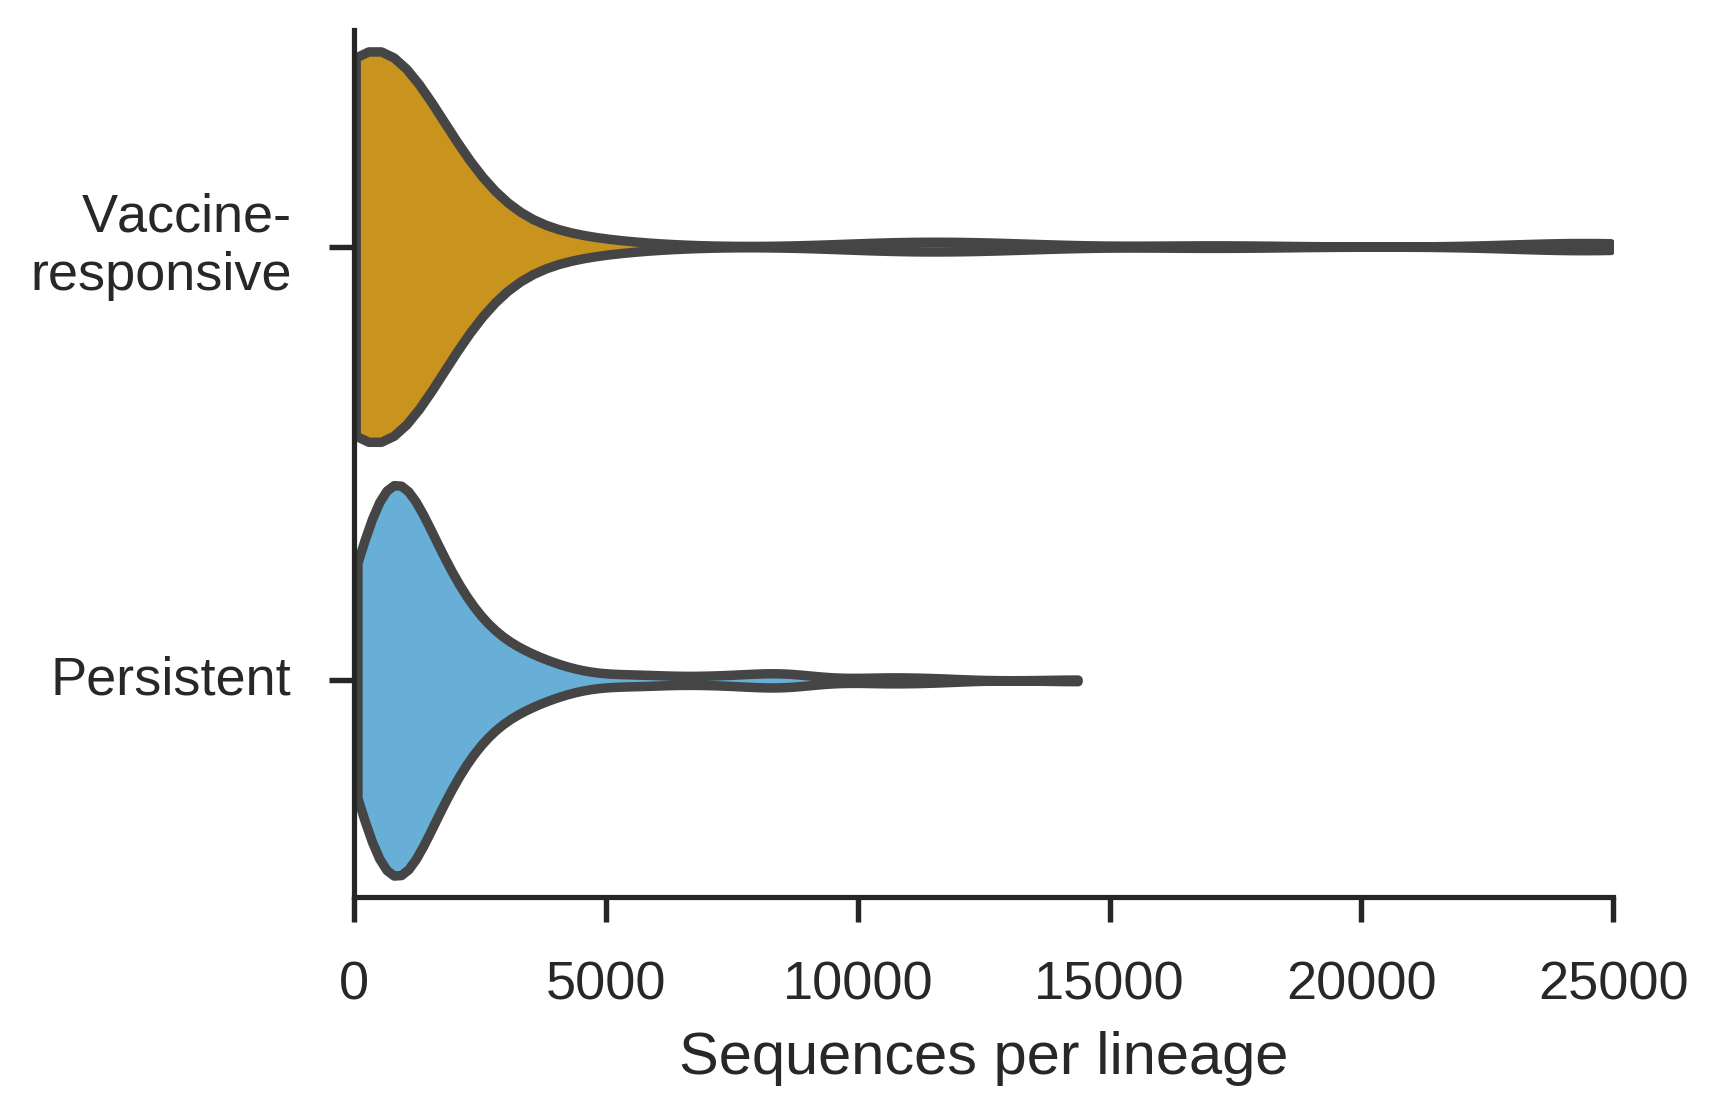

In [39]:
# Total number of sequences detected in each lineage
x1 = df_expanded["num_unique_seqs"]
x2 = df_persistent["num_unique_seqs"]

data = [x1, x2]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, inner=None, orient="h", ax=ax, palette=myColors, width=0.9, scale="width")
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent"], rotation=0)
ax.set_xlabel("Sequences per lineage")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_num_unique_seqs", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x1)
print "STD", np.std(x1)
print
print "Persistent"
print "Mean", np.mean(x2)
print "STD", np.std(x2)
print
print scipy.stats.mannwhitneyu(x1, x2)

Expanded
Mean 398.313186813
STD 1011.87018981

Persistent
Mean 186.784172662
STD 203.445551702

MannwhitneyuResult(statistic=37227.5, pvalue=0.3560250233908055)


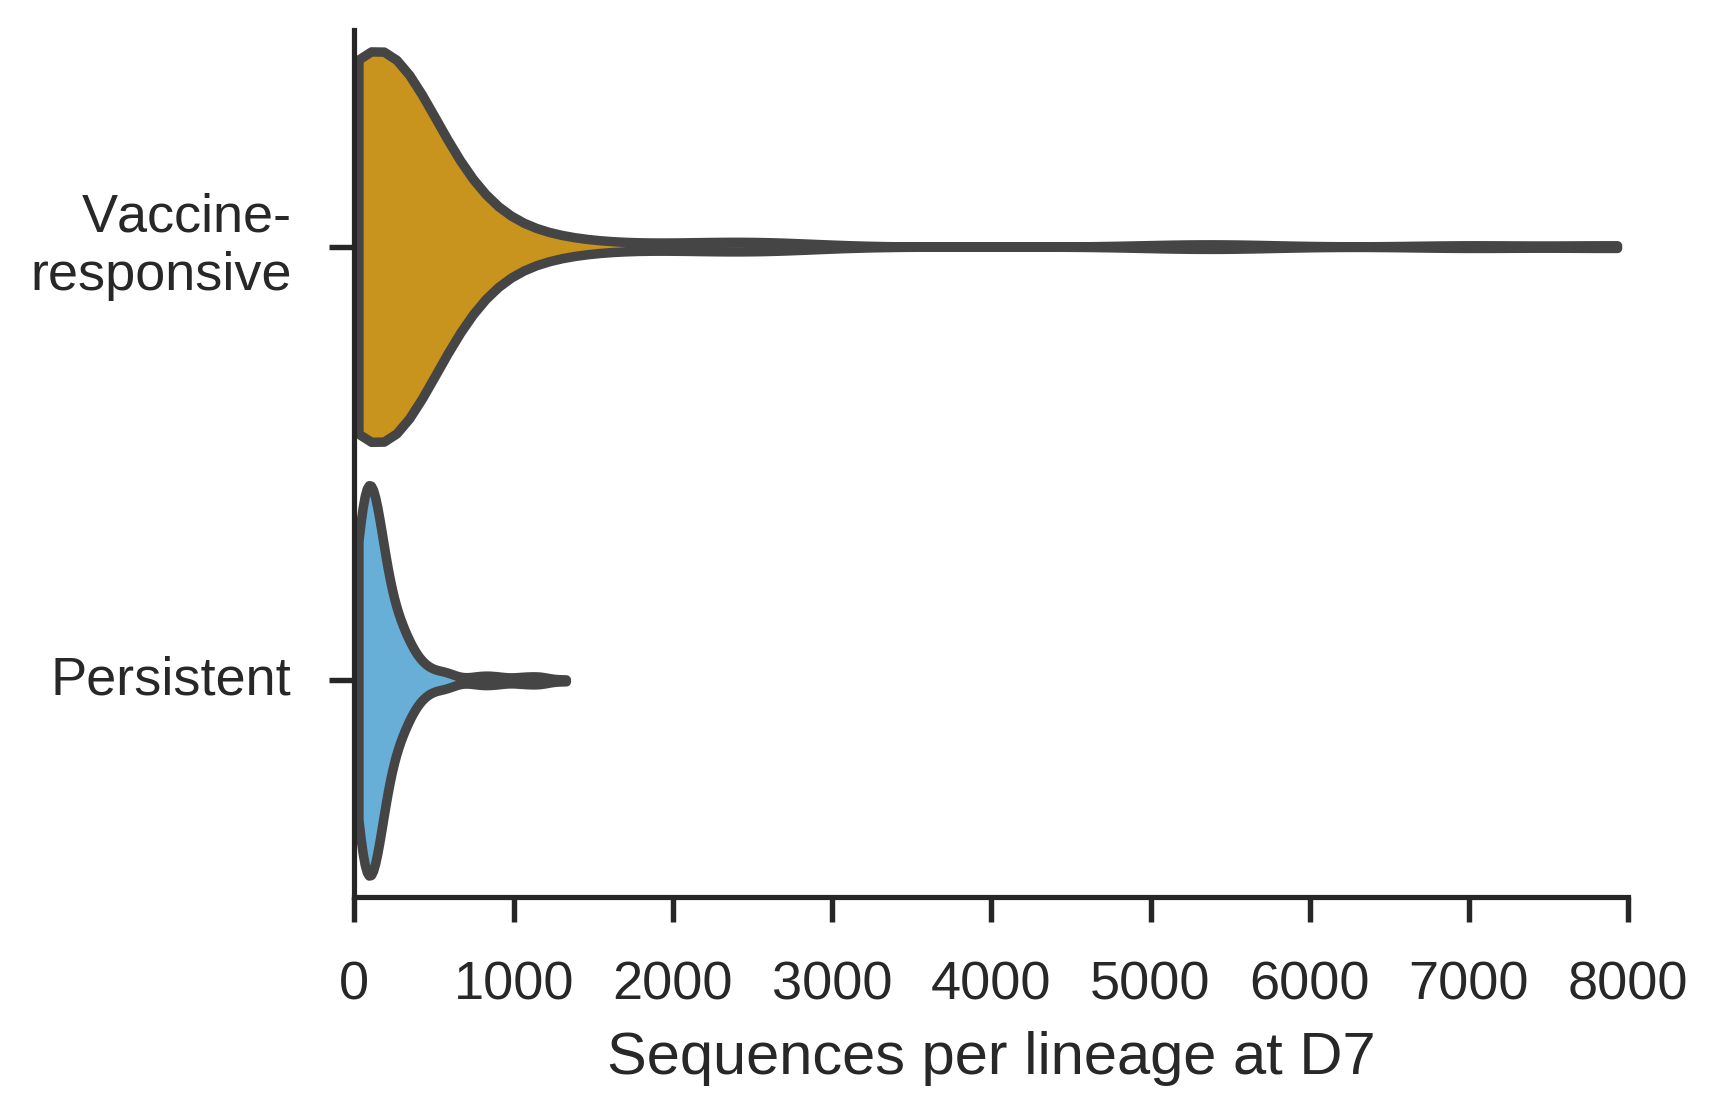

In [40]:
# Number of sequences at D7 (no 2x300 reads)

x1 = df_expanded["sequences_V6"]
x2 = df_persistent["sequences_V6"]

data = [x1, x2]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, inner=None, orient="h", ax=ax, palette=myColors, width=0.9, scale="width")
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent"], rotation=0)
ax.set_xlabel("Sequences per lineage at D7")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_sequences_V6", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x1)
print "STD", np.std(x1)
print
print "Persistent"
print "Mean", np.mean(x2)
print "STD", np.std(x2)
print
print scipy.stats.mannwhitneyu(x1, x2)

Expanded
Mean 903.098901099
STD 2925.46266109

Persistent
Mean 276.551558753
STD 741.838579178

MannwhitneyuResult(statistic=36015.0, pvalue=0.16065694513330936)


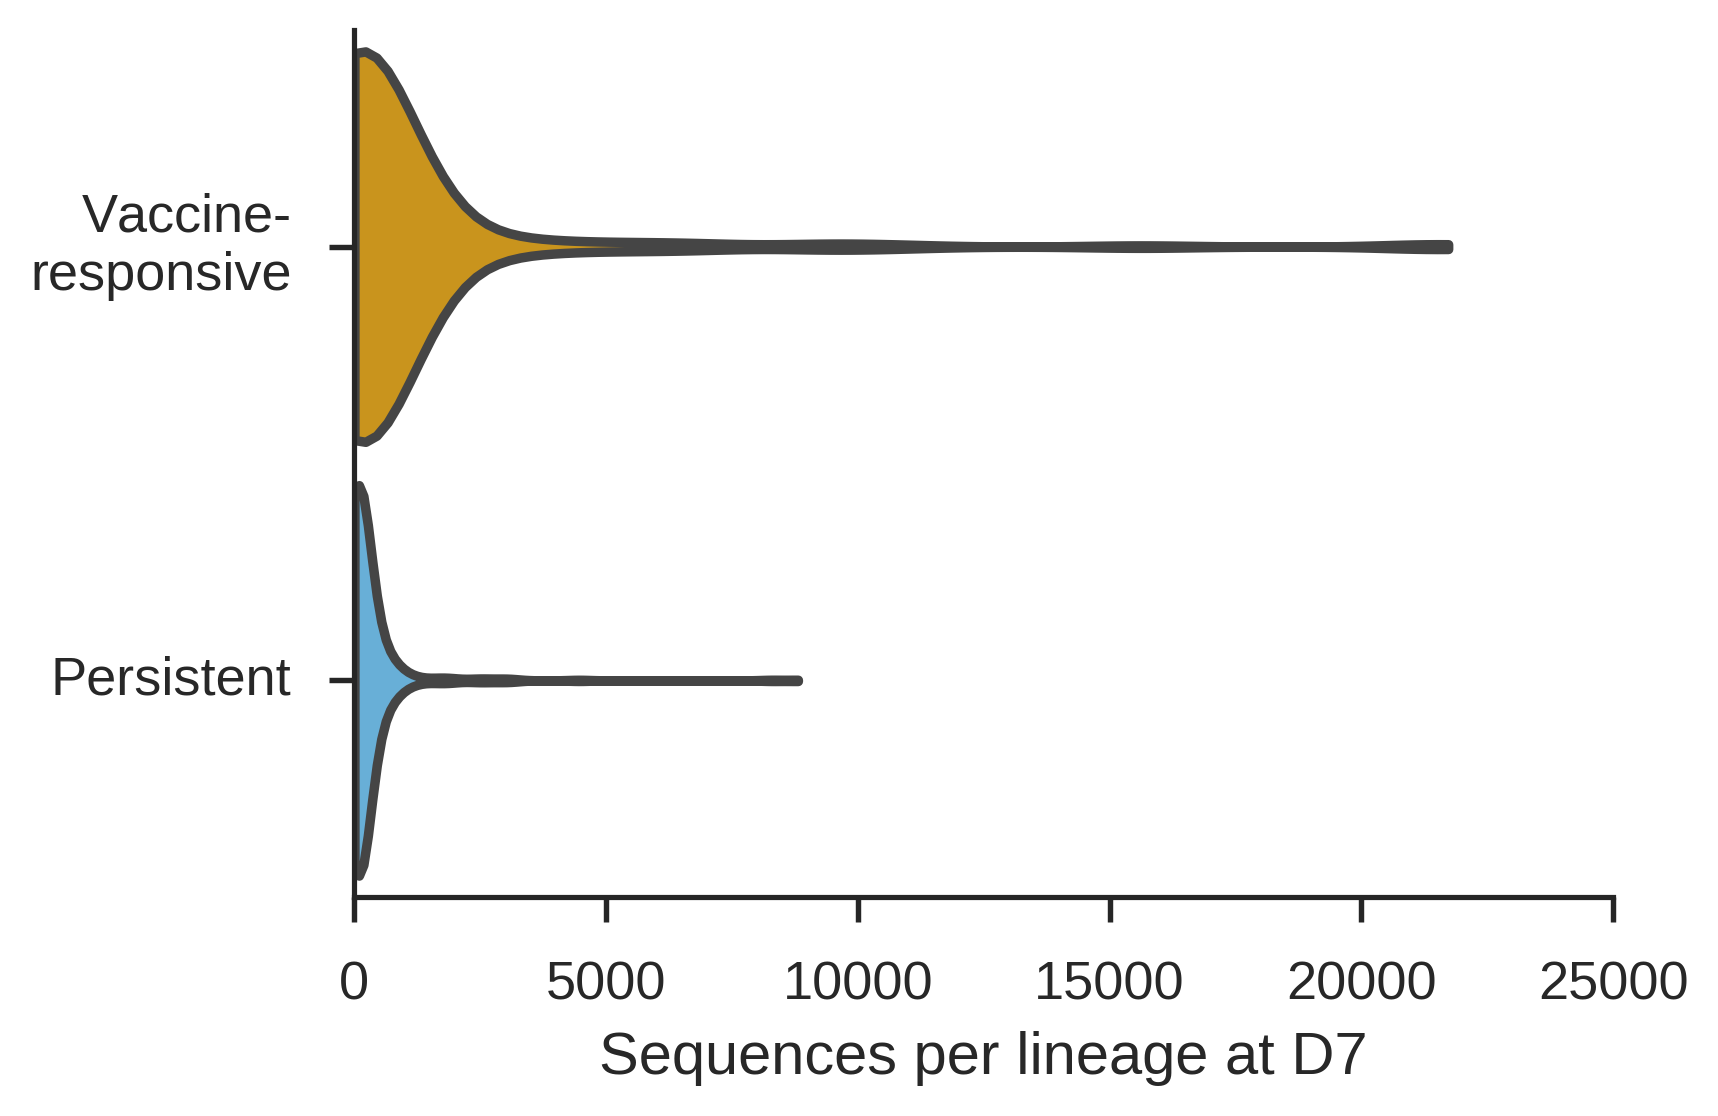

In [41]:
# Number of sequences at D7 (only 2x300 reads)

x1 = df_expanded["sequences_V6_Full"]
x2 = df_persistent["sequences_V6_Full"]

data = [x1, x2]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, inner=None, orient="h", ax=ax, palette=myColors, width=0.9, scale="width")
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent"], rotation=0)
ax.set_xlabel("Sequences per lineage at D7")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_sequences_V6_Full", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x1)
print "STD", np.std(x1)
print
print "Persistent"
print "Mean", np.mean(x2)
print "STD", np.std(x2)
print
print scipy.stats.mannwhitneyu(x1, x2)

# Plot isotype compositions

In [32]:
# Calculate fraction of sequences of each isotype for each lineage

start_time = time.time()

# Initialize fractions to 0
for isotype in ["IgM", "IgD", "IgG", "IgA", "IgE"]:
    df_expanded["frac_"+isotype] = 0.
    df_persistent["frac_"+isotype] = 0.
    
for lineage_uid, group in df_seqs_expanded.groupby("lineage_uid"):
    fracs = group["isotype"].value_counts(normalize=True)
    for isotype in fracs.index:
        df_expanded["frac_" + isotype].loc[lineage_uid] = fracs[isotype]

for lineage_uid, group in df_seqs_persistent.groupby("lineage_uid"):
    fracs = group["isotype"].value_counts(normalize=True)
    for isotype in fracs.index:
        df_persistent["frac_" + isotype].loc[lineage_uid] = fracs[isotype]
        
# Add IgM and IgD together
df_expanded["frac_IgMIgD"] = df_expanded["frac_IgM"] + df_expanded["frac_IgD"]
df_persistent["frac_IgMIgD"] = df_persistent["frac_IgM"] + df_persistent["frac_IgD"]

print "Elapsed time (s):", time.time() - start_time

Elapsed time (s): 149.785963058


Expanded
Mean 0.0553795260121
STD 0.19935722103

Persistent
Mean 0.630664934358
STD 0.365404286369

MannwhitneyuResult(statistic=7002.5, pvalue=2.3105591013853149e-58)


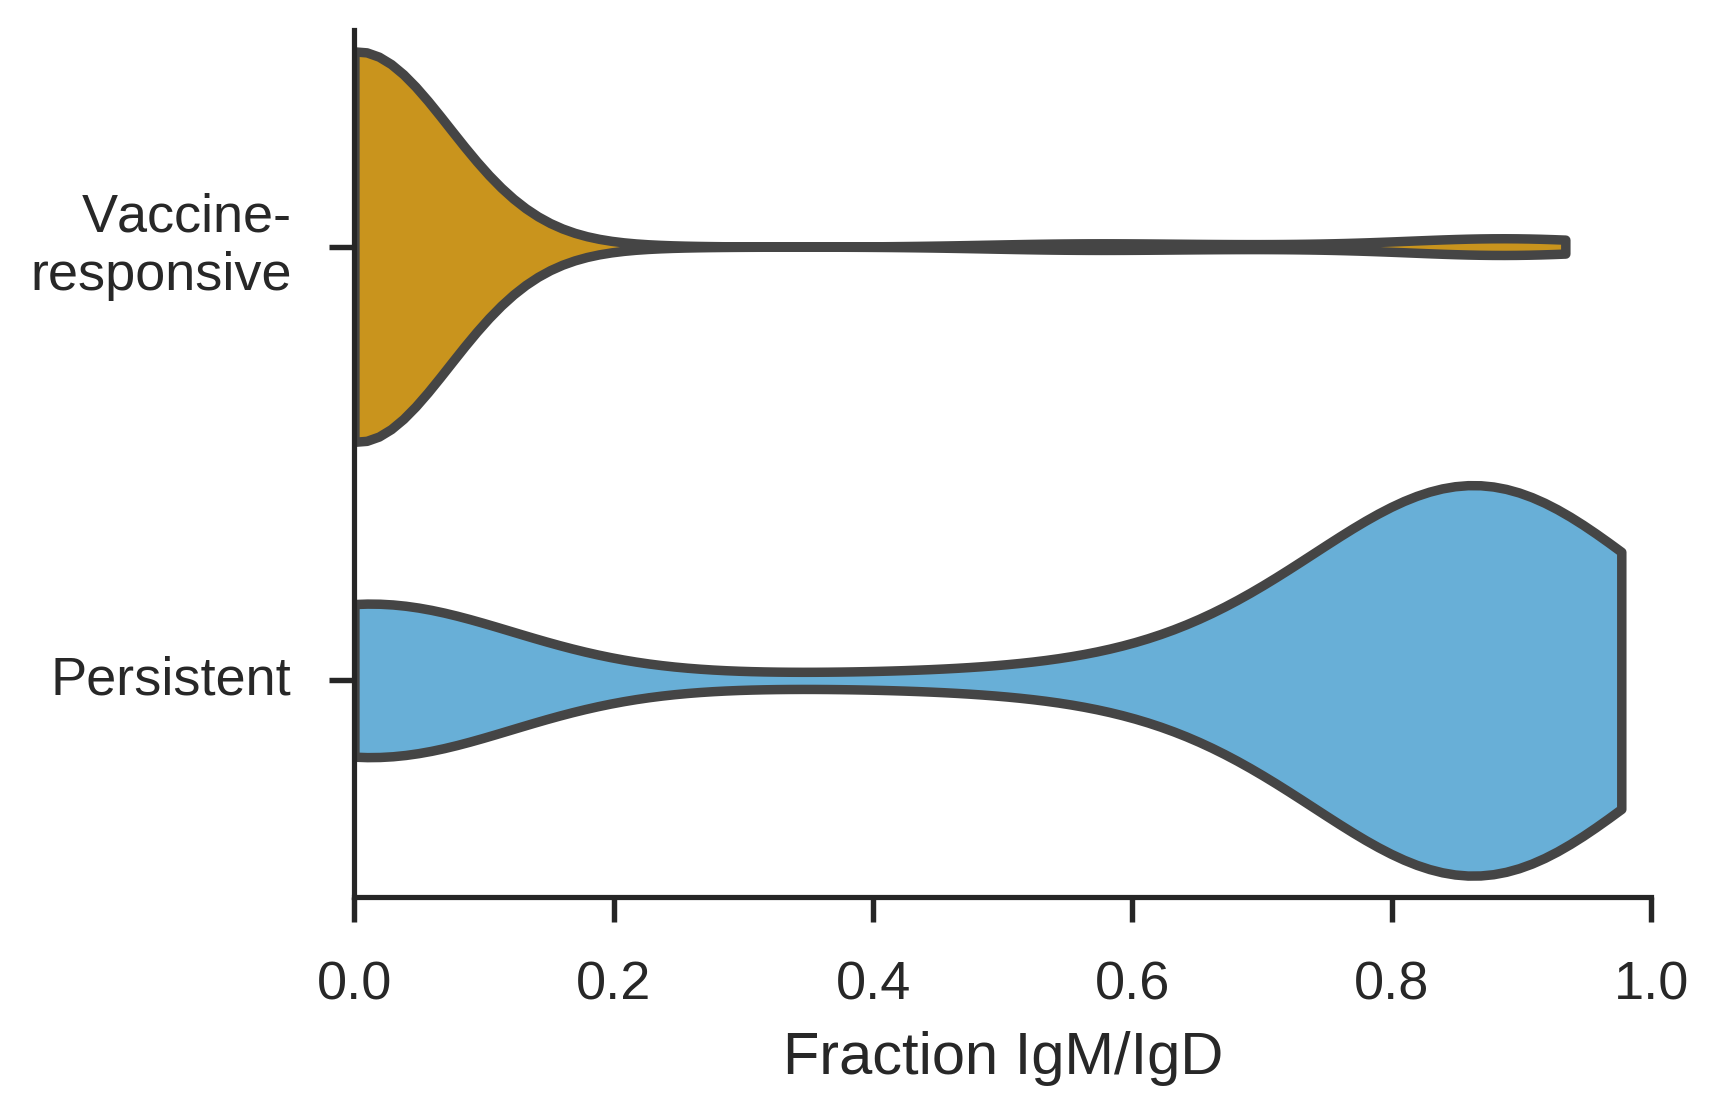

In [42]:
# Plot fraction IgM/IgD per lineage

x1 = df_expanded["frac_IgM"]
x2 = df_persistent["frac_IgM"]

data = [x1, x2]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, inner=None, orient="h", ax=ax, palette=myColors, width=0.9, scale="width")
ax.set_xlim([0,1])
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent"], rotation=0)
ax.set_xlabel("Fraction IgM/IgD")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_frac_IgMIgD", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x1)
print "STD", np.std(x1)
print
print "Persistent"
print "Mean", np.mean(x2)
print "STD", np.std(x2)
print
print scipy.stats.mannwhitneyu(x1, x2)

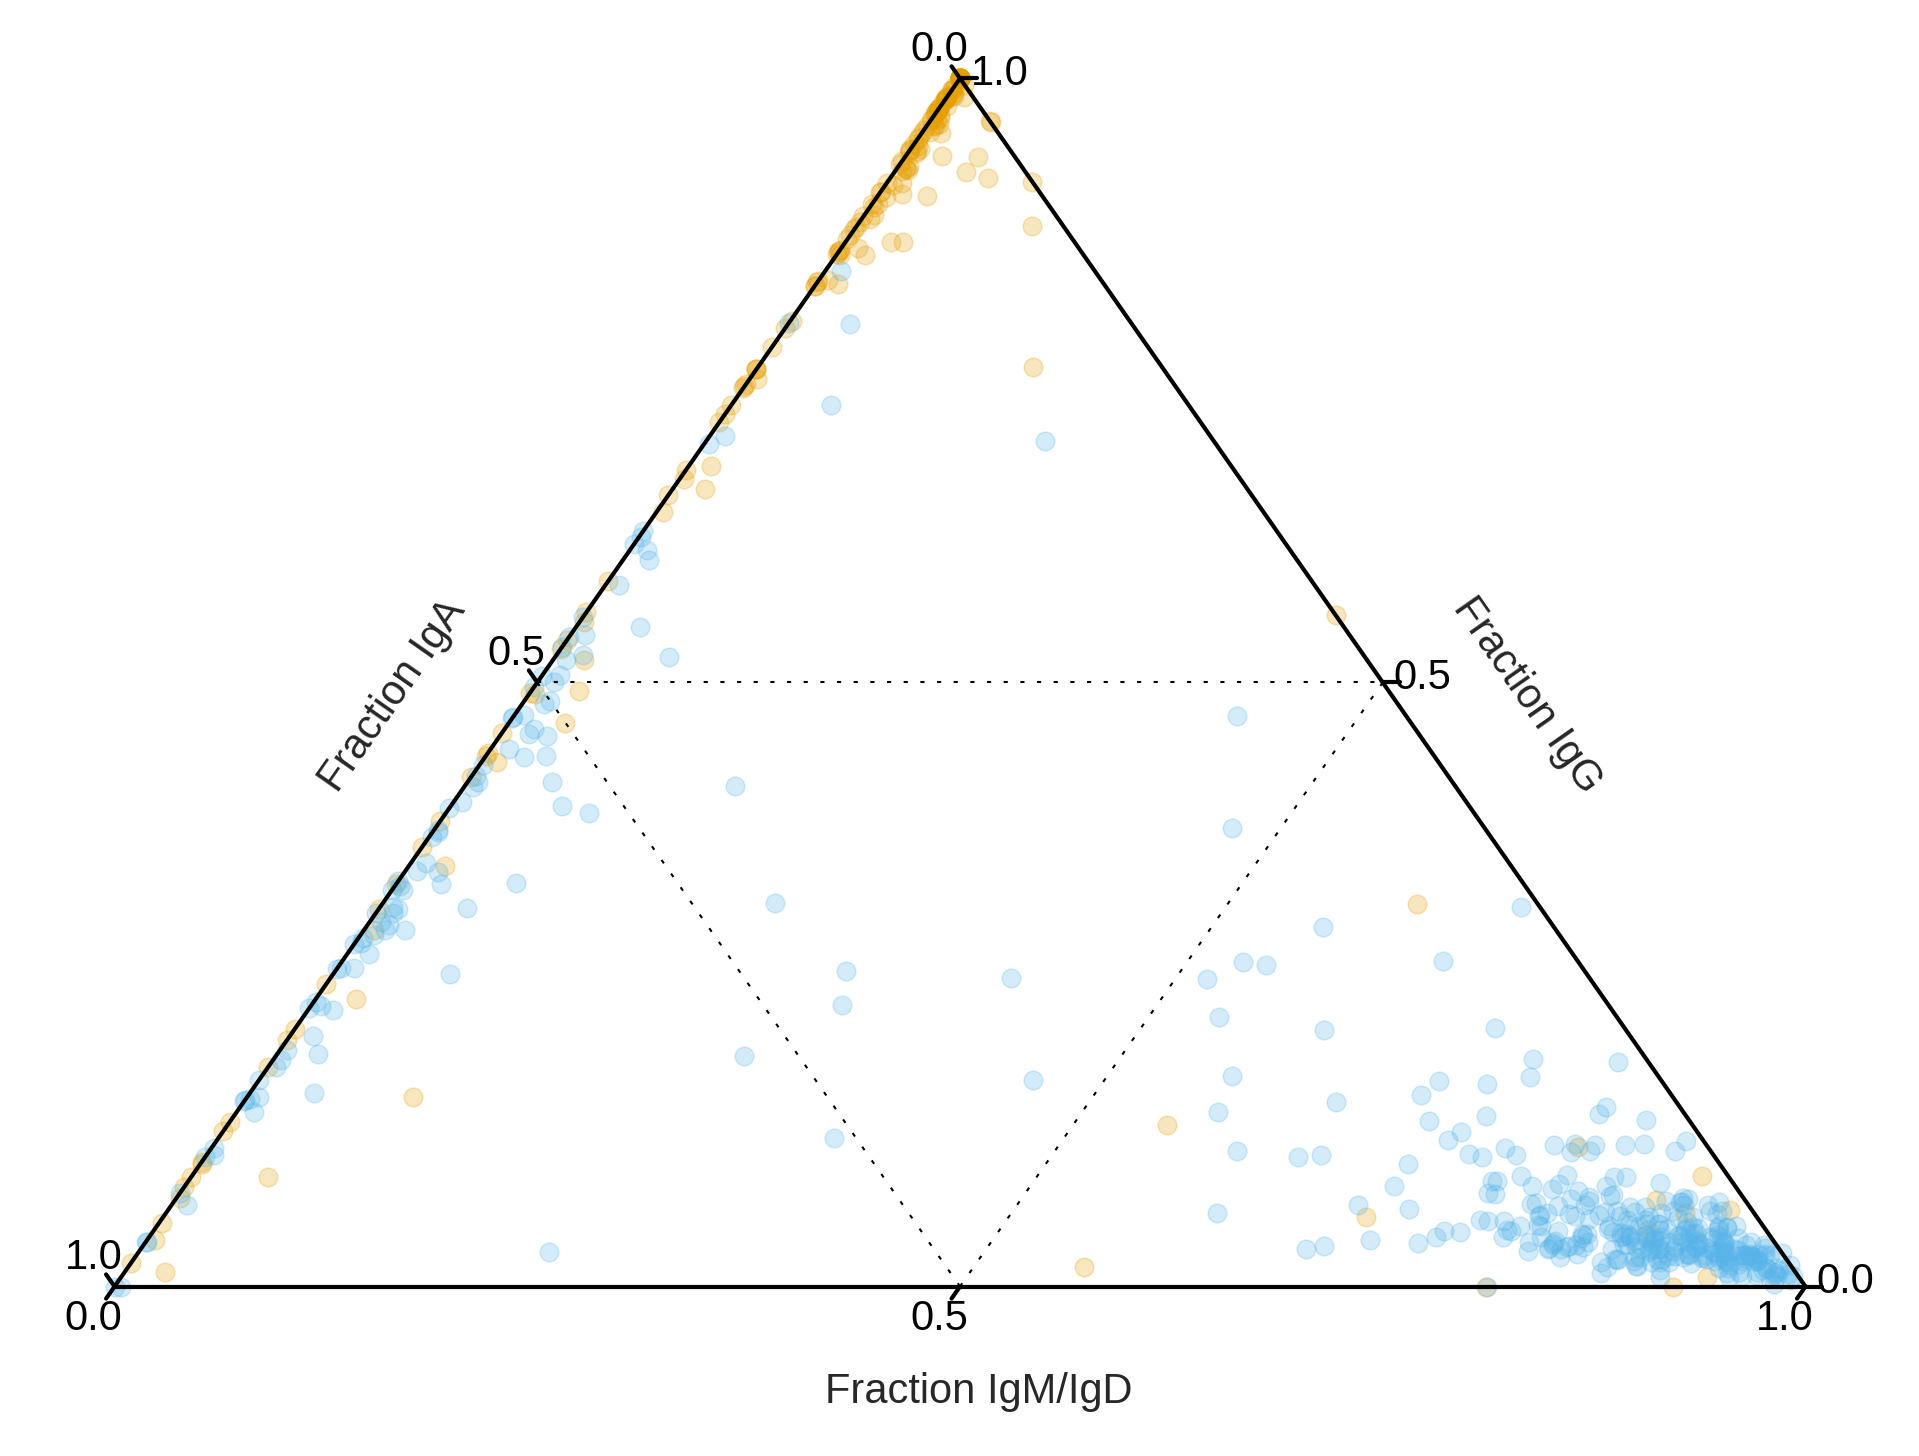

In [34]:
# Plot fraction IgM/IgG/IgA per lineage

# Simplex scatter (3-simplex: IgM+IgD (Naive), IgG, IgA)
import ternary

x1 = df_expanded["frac_IgM"] + df_expanded["frac_IgD"]
x2 = df_expanded["frac_IgG"]
x3 = df_expanded["frac_IgA"]
X = zip(x1, x2, x3)

y1 = df_persistent["frac_IgM"] + df_persistent["frac_IgD"]
y2 = df_persistent["frac_IgG"]
y3 = df_persistent["frac_IgA"]
Y = zip(y1, y2, y3)

fig, tax = ternary.figure(scale=1)
fig.set_size_inches(8,6)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.5, color="k")
tax.scatter(X, marker="o", color=myColors[0], label="Vaccine-responsive", alpha=0.25)
tax.scatter(Y, marker="o", color=myColors[1], label="Persistent", alpha=0.25)
fontsize=10
tax.left_axis_label("Fraction IgA", fontsize=fontsize, offset=0.1)
tax.right_axis_label("Fraction IgG", fontsize=fontsize, offset=0.1)
tax.bottom_axis_label("Fraction IgM/IgD", fontsize=fontsize)
tax.ticks(axis='lbr', multiple=0.5, linewidth=1)
tax.clear_matplotlib_ticks()
sns.despine(left=True, bottom=True)
save_figure(fig, "MolecularFeatures_isotype_ternary", output_dir, output_suffix, output_formats, savefig_args)

# Plot mutation density

Expanded
Mean 0.030518
STD 0.016068
Median 0.028992

Persistent
Mean 0.011642
STD 0.014877
Median 0.0083313

Repertoire
Mean 0.016708
STD 0.018082
Median 0.0092621

MannwhitneyuResult(statistic=43715491664.5, pvalue=0.0)
MannwhitneyuResult(statistic=115606375144.0, pvalue=0.0)
MannwhitneyuResult(statistic=446027034025.5, pvalue=0.0)


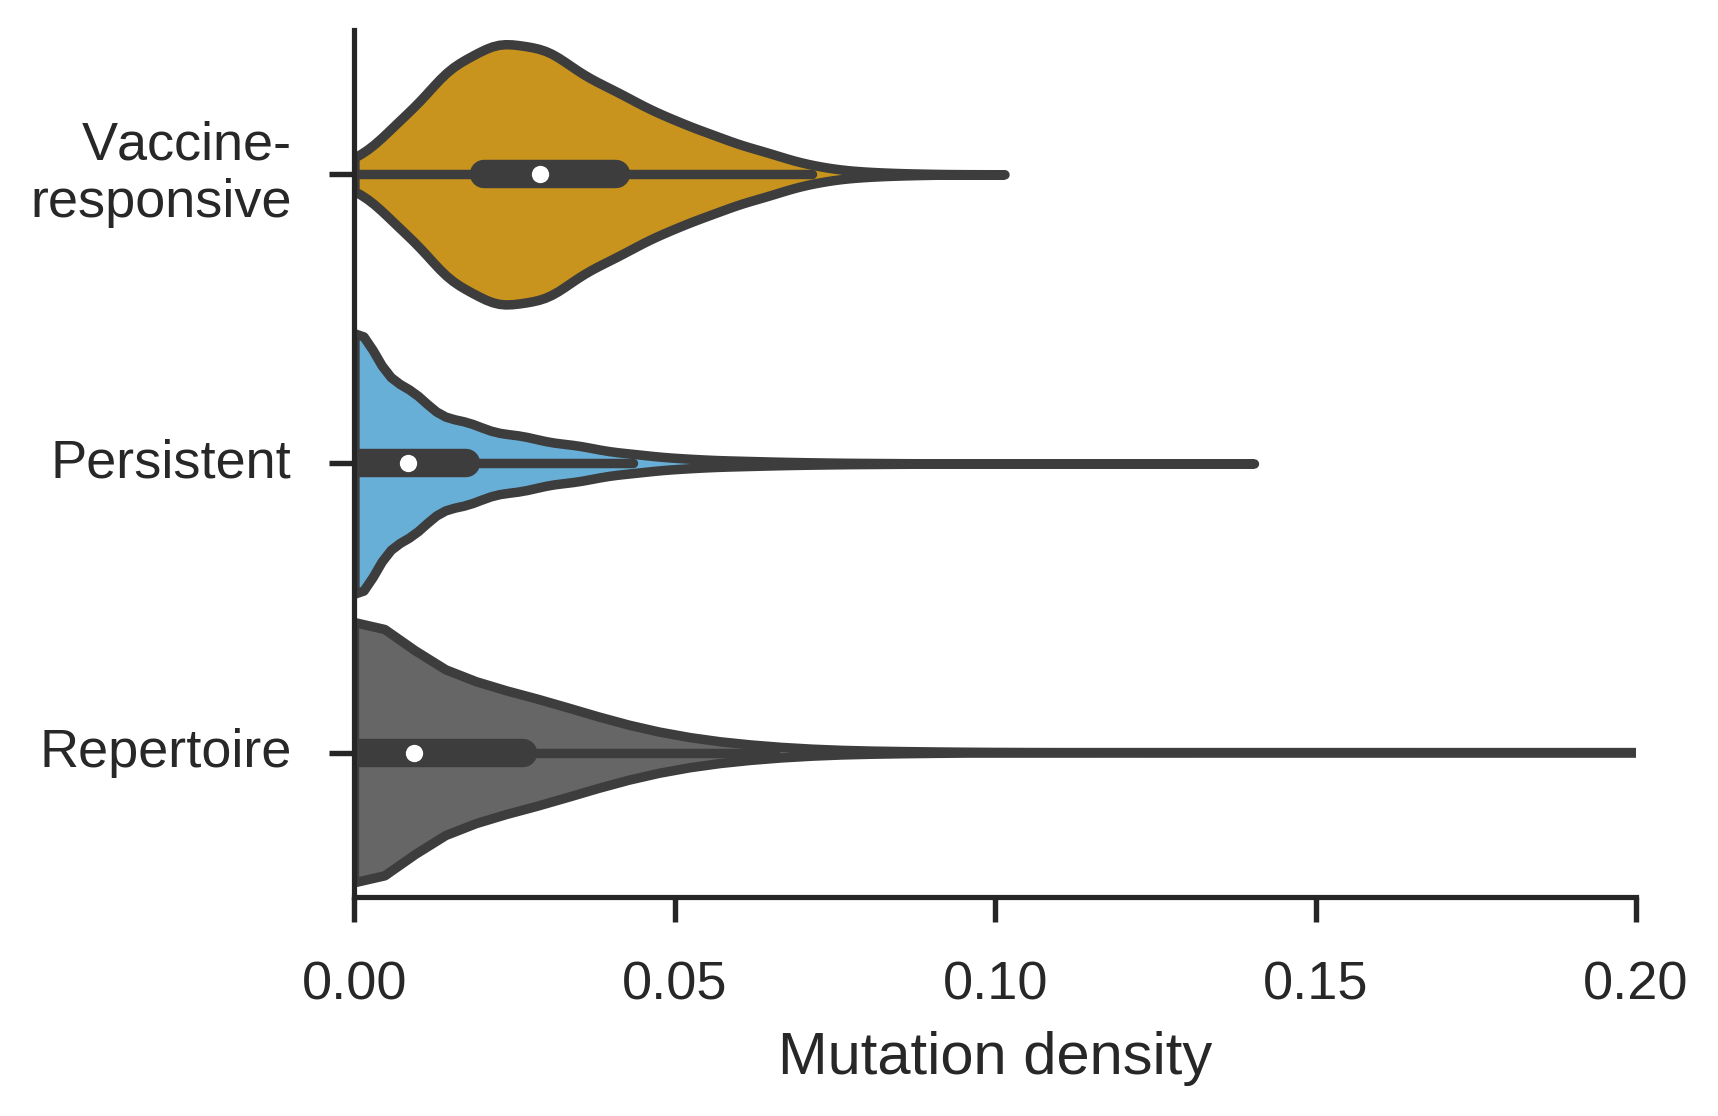

In [43]:
feature = "mut_germline_density"
x = df_seqs_expanded[feature]
y = df_seqs_persistent[feature]
z = df_seqs_all[feature]

data = [x, y, z]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, orient="h", ax=ax, palette=myColors, width=0.9, scale="width", bw=0.25)
ax.set_xlim(0, 0.2)
plt.locator_params(axis='x', nbins=5)
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent", "Repertoire"], rotation=0)
ax.set_xlabel("Mutation density")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_mut_germline_density", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x)
print "STD", np.std(x)
print "Median", np.median(x)
print
print "Persistent"
print "Mean", np.nanmean(y)
print "STD", np.std(y)
print "Median", np.median(y)
print
print "Repertoire"
print "Mean", np.nanmean(z)
print "STD", np.std(z)
print "Median", np.median(z)
print
print scipy.stats.mannwhitneyu(x, y, alternative="two-sided")
print scipy.stats.mannwhitneyu(x, z, alternative="two-sided")
print scipy.stats.mannwhitneyu(y, z, alternative="two-sided")

# Plot CDR3 length

Expanded
Mean 49.702549799
STD 8.48408214017
Median 50.0

Persistent
Mean 33.9460540846
STD 6.35682981987
Median 32.0

Repertoire
Mean 37.7539761161
STD 10.6509167696
Median 35.0

MannwhitneyuResult(statistic=49936324424.0, pvalue=0.0)
MannwhitneyuResult(statistic=128963924296.5, pvalue=0.0)
MannwhitneyuResult(statistic=429663663887.0, pvalue=0.0)


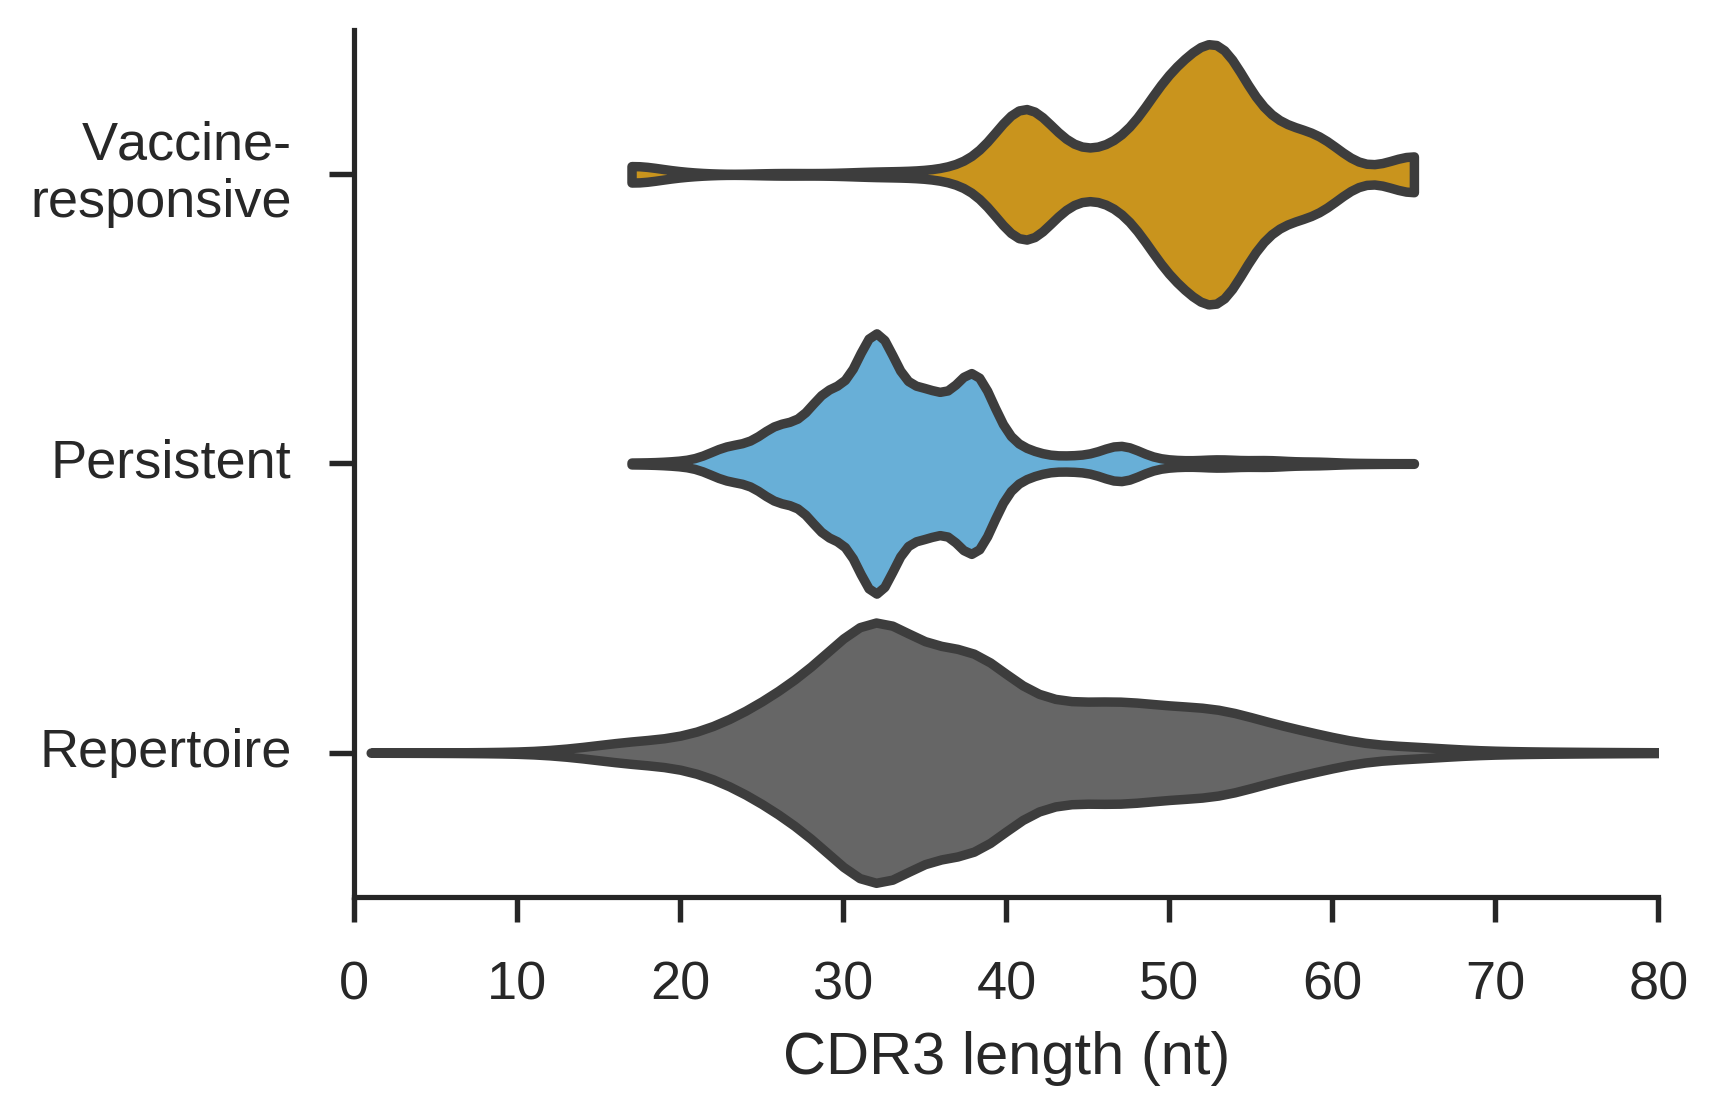

In [44]:
feature = "cdr3_length"
x = df_seqs_expanded[feature]
y = df_seqs_persistent[feature]
z = df_seqs_all[feature]

data = [x, y, z]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.violinplot(data=data, cut=0, inner=None, orient="h", ax=ax, palette=myColors, width=0.9, scale="width", bw=0.2)
ax.set_yticklabels(["Vaccine-\nresponsive", "Persistent", "Repertoire"], rotation=0)
ax.set_xlim(left=0, right=80)
ax.set_xlabel("CDR3 length (nt)")
sns.despine()
plt.tight_layout()
save_figure(fig, "MolecularFeatures_cdr3_length", output_dir, output_suffix, output_formats, savefig_args)

print "Expanded"
print "Mean", np.mean(x)
print "STD", np.std(x)
print "Median", np.median(x)
print
print "Persistent"
print "Mean", np.mean(y)
print "STD", np.std(y)
print "Median", np.median(y)
print
print "Repertoire"
print "Mean", np.mean(z)
print "STD", np.std(z)
print "Median", np.median(z)
print
print scipy.stats.mannwhitneyu(x, y, alternative="two-sided")
print scipy.stats.mannwhitneyu(x, z, alternative="two-sided")
print scipy.stats.mannwhitneyu(y, z, alternative="two-sided")